<a href="https://colab.research.google.com/github/saishdesai23/Profile-based-Candidate-Job-Recommendation-System/blob/main/Job_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a Job Recommendation Sytem

## Authors -
Anish Shetty
Asmita Dabholkar
Saish Desai

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Installing required libraries

In [20]:
pip install spacy

## Importing required libraries

In [21]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt

# importing packages for text pre-porcessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup # package used for web scrapping to remove the HTML tags from the text ( not needed here)
import re # A package dealing with regular experession to remove punctuation and numbers
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
jobs_data = pd.read_csv("/content/drive/MyDrive/Text_Mining_Final_Project/Job_Recommendation_System/data/Combined_Jobs_Final.csv")
jobs_data.head()

,Job.ID,Provider,Status,Slug,Title,Position,Company,City,State.Name,State.Code,...,Industry,Job.Description,Requirements,Salary,Listing.Start,Listing.End,Employment.Type,Education.Required,Created.At,Updated.At
0,111,1,open,palo-alto-ca-tacolicious-server,Server @ Tacolicious,Server,Tacolicious,Palo Alto,California,CA,...,Food and Beverages,Tacolicious' first Palo Alto store just opened...,NaN,8.00,NaN,NaN,Part-Time,NaN,2013-03-12 02:08:28 UTC,2014-08-16 15:35:36 UTC
1,113,1,open,san-francisco-ca-claude-lane-kitchen-staff-chef,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,California,CA,...,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...,NaN,0.00,NaN,NaN,Part-Time,NaN,2013-04-12 08:36:36 UTC,2014-08-16 15:35:36 UTC
2,117,1,open,san-francisco-ca-machka-restaurants-corp-barte...,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,California,CA,...,Food and Beverages,We are a popular Mediterranean wine bar and re...,NaN,11.00,NaN,NaN,Part-Time,NaN,2013-07-16 09:34:10 UTC,2014-08-16 15:35:37 UTC
3,121,1,open,brisbane-ca-teriyaki-house-server,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,California,CA,...,Food and Beverages,● Serve food/drinks to customers in a profess...,NaN,10.55,NaN,NaN,Part-Time,NaN,2013-09-04 15:40:30 UTC,2014-08-16 15:35:38 UTC
4,127,1,open,los-angeles-ca-rosa-mexicano-sunset-kitchen-st...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,California,CA,...,Food and Beverages,"Located at the heart of Hollywood, we are one ...",NaN,10.55,NaN,NaN,Part-Time,NaN,2013-07-17 15:26:18 UTC,2014-08-16 15:35:40 UTC


We will only extract the columns ‘Job.ID’, ‘Title’, ‘Position’, ‘Company’, ’City’, ’Job_Description’ needed for creating the recommendation system

In [23]:
jobs_data = jobs_data[['Job.ID', 'Title', 'Position', 'Company', 'City', 'Employment.Type','Job.Description']]

In [24]:
jobs_data.head()

,Job.ID,Title,Position,Company,City,Employment.Type,Job.Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


## Data Cleaning

In [25]:
jobs_data.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
City                135
Employment.Type      10
Job.Description      56
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


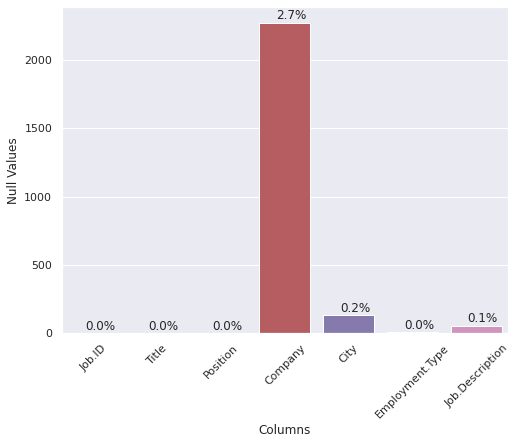

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
x = jobs_data.columns
y = jobs_data.isnull().sum()
plt.figure(figsize=(8,6))
sns.set()
sns.barplot(x,y)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+0.5,
            height + 2,
            str(100*round(int(height)/jobs_data.shape[0], 3)) +"%",
            fontsize=12, ha='center', va='bottom')
ax.set_xlabel("Columns")
ax.set_ylabel("Null Values")
plt.xticks(rotation=45)

plt.show()

In [27]:
df_null_city = jobs_data[pd.isnull(jobs_data['City'])]
print(df_null_city.shape)
df_null_city.head()

(135, 7)


,Job.ID,Title,Position,Company,City,Employment.Type,Job.Description
3425,142044,Registered Nurse (RN) @ St. Francis Hospital,Registered Nurse (RN),St. Francis Hospital,NaN,Full-Time/Part-Time,Under the direction of the Clinical Coordinato...
3433,142054,Sales Representative - Business Development Op...,Sales Representative - Business Development Op...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3434,142055,New Business Executive @ CHI Payment Systems,New Business Executive,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3435,142056,Outside Sales Representative (Business Develop...,Outside Sales Representative (Business Develop...,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."
3436,142057,Outside Sales Representative @ CHI Payment Sys...,Outside Sales Representative,CHI Payment Systems,NaN,Full-Time/Part-Time,"If you&rsquo;re energetic, motivated, hardwork..."


In [28]:
df_null_city.groupby(['Company'])['City'].count() 

Company
Academic Year In America                0
CBS Healthcare Services and Staffing    0
CHI Payment Systems                     0
Driveline Retail                        0
Educational Testing Services            0
Genesis Health System                   0
Genesis Health Systems                  0
Home Instead Senior Care                0
St. Francis Hospital                    0
Volvo Group                             0
Name: City, dtype: int64

In [29]:
#replacing nan with thier headquarters location
jobs_data['Company'] = jobs_data['Company'].replace(['Genesis Health Systems'], 'Genesis Health System')
jobs_data.loc[jobs_data.Company == 'CHI Payment Systems', 'City'] = 'Illinois'
jobs_data.loc[jobs_data.Company == 'Academic Year In America', 'City'] = 'Stamford'
jobs_data.loc[jobs_data.Company == 'CBS Healthcare Services and Staffing ', 'City'] = 'Urbandale'
jobs_data.loc[jobs_data.Company == 'Driveline Retail', 'City'] = 'Coppell'
jobs_data.loc[jobs_data.Company == 'Educational Testing Services', 'City'] = 'New Jersey'
jobs_data.loc[jobs_data.Company == 'Genesis Health System', 'City'] = 'Davennport'
jobs_data.loc[jobs_data.Company == 'Home Instead Senior Care', 'City'] = 'Nebraska'
jobs_data.loc[jobs_data.Company == 'St. Francis Hospital', 'City'] = 'New York'
jobs_data.loc[jobs_data.Company == 'Volvo Group', 'City'] = 'Washington'
jobs_data.loc[jobs_data.Company == 'CBS Healthcare Services and Staffing', 'City'] = 'Urbandale'



In [30]:
jobs_data.isnull().sum()

Job.ID                0
Title                 0
Position              0
Company            2271
City                  0
Employment.Type      10
Job.Description      56
dtype: int64

In [31]:
#The employement type NA are from Uber so we assume it as part-time and full time
df_null_emp = jobs_data[pd.isnull(jobs_data['Employment.Type'])]
df_null_emp.head()

,Job.ID,Title,Position,Company,City,Employment.Type,Job.Description
10768,153197,Driving Partner @ Uber,Driving Partner,Uber,San Francisco,NaN,Uber is changing the way the world moves. From...
10769,153198,Driving Partner @ Uber,Driving Partner,Uber,Los Angeles,NaN,Uber is changing the way the world moves. From...
10770,153199,Driving Partner @ Uber,Driving Partner,Uber,Chicago,NaN,Uber is changing the way the world moves. From...
10771,153200,Driving Partner @ Uber,Driving Partner,Uber,Boston,NaN,Uber is changing the way the world moves. From...
10772,153201,Driving Partner @ Uber,Driving Partner,Uber,Ann Arbor,NaN,Uber is changing the way the world moves. From...


In [32]:
jobs_data['Employment.Type'].unique()

jobs_data['Employment.Type']=jobs_data['Employment.Type'].fillna('Full-Time/Part-Time')
jobs_data.groupby(['Employment.Type'])['Company'].count()
jobs_data.head()

,Job.ID,Title,Position,Company,City,Employment.Type,Job.Description
0,111,Server @ Tacolicious,Server,Tacolicious,Palo Alto,Part-Time,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,San Francisco,Part-Time,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,San Francisco,Part-Time,We are a popular Mediterranean wine bar and re...
3,121,Server @ Teriyaki House,Server,Teriyaki House,Brisbane,Part-Time,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,Kitchen Staff/Chef,Rosa Mexicano - Sunset,Los Angeles,Part-Time,"Located at the heart of Hollywood, we are one ..."


In [33]:
jobs_data["text"] = jobs_data["Position"].map(str) + " " + jobs_data["Company"] +" "+ jobs_data["City"]+ " "+jobs_data['Employment.Type']+" "+jobs_data['Job.Description'] +" "+jobs_data['Title']

jobs_data = jobs_data[['Job.ID', 'text','Title','Job.Description']]
jobs_data = jobs_data.fillna(" ")
jobs_data.head()

,Job.ID,text,Title,Job.Description
0,111,Server Tacolicious Palo Alto Part-Time Tacolic...,Server @ Tacolicious,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef Claude Lane San Francisco P...,Kitchen Staff/Chef @ Claude Lane,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender Machka Restaurants Corp. San Francis...,Bartender @ Machka Restaurants Corp.,We are a popular Mediterranean wine bar and re...
3,121,Server Teriyaki House Brisbane Part-Time ● Se...,Server @ Teriyaki House,● Serve food/drinks to customers in a profess...
4,127,Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset,"Located at the heart of Hollywood, we are one ..."


In [34]:
df_all = jobs_data[['Job.ID', 'text', 'Title']]

df_all = df_all.fillna(" ")

df_all = df_all[:10000]
df_all

,Job.ID,text,Title
0,111,Server Tacolicious Palo Alto Part-Time Tacolic...,Server @ Tacolicious
1,113,Kitchen Staff/Chef Claude Lane San Francisco P...,Kitchen Staff/Chef @ Claude Lane
2,117,Bartender Machka Restaurants Corp. San Francis...,Bartender @ Machka Restaurants Corp.
3,121,Server Teriyaki House Brisbane Part-Time ● Se...,Server @ Teriyaki House
4,127,Kitchen Staff/Chef Rosa Mexicano - Sunset Los ...,Kitchen Staff/Chef @ Rosa Mexicano - Sunset
...,...,...,...
9995,150545,Administrative Assistant OfficeTeam West Des M...,Administrative Assistant @ OfficeTeam
9996,150546,Customer Service Representatives OfficeTeam Co...,Customer Service Representatives @ OfficeTeam
9997,150547,Medical Front Office OfficeTeam Tucson Seasona...,Medical Front Office @ OfficeTeam
9998,150548,Data Entry Clerk OfficeTeam Colorado Springs S...,Data Entry Clerk @ OfficeTeam


In [35]:
# initializing lemmatizing algorithm
wnl = WordNetLemmatizer() # lemmatization

def text_clean_preprocess(raw_text : str):
    """
    This function will clean the data and perform certain preprocessing step of stemming/lemmatizing the words in 
    the tweet. Finally the function will remove stopwords and will only consider with words with a character length
    ranging from 2 to 10
    """
    newString = raw_text.lower() # case folding
    newString = BeautifulSoup(newString, "lxml").text # removing html tags
    text = re.sub("[^a-zA-Z]"," ", newString) # removing all non-alphabetic characters
    text = re.sub("'","", text)
    text = re.sub("\\d|\\W"," ", text)
    words = text.split()
    meaningful_words = [wnl.lemmatize(w) for w in words if w not in stopwords.words("english") and 2< len(w)<=15]
    return " ".join(meaningful_words)  

In [36]:
df_all['text'] = df_all['text'].apply(text_clean_preprocess)

In [37]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf_jobid = tfidf_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
tfidf_jobid

<10000x17926 sparse matrix of type '<class 'numpy.float64'>'
	with 1020706 stored elements in Compressed Sparse Row format>

Now we will focus on creating the dataframe for users and their job preferences

Job View Data

In [38]:
# Job view data
job_view_data = pd.read_csv("/content/drive/MyDrive/Text_Mining_Final_Project/Job_Recommendation_System/data/Job_Views.csv")
job_view_data.head(5)

,Applicant.ID,Job.ID,Title,Position,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At
0,10000,73666,Cashiers & Valets Needed! @ WallyPark,Cashiers & Valets Needed!,WallyPark,Newark,New Jersey,NJ,NaN,2014-12-12 20:12:35 UTC,2014-12-12 20:31:24 UTC,1129.0,2014-12-12 20:12:35 UTC,2014-12-12 20:12:35 UTC
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-12 20:08:50 UTC,2014-12-12 20:10:15 UTC,84.0,2014-12-12 20:08:50 UTC,2014-12-12 20:08:50 UTC
2,10001,84141,Part Time Showroom Sales / Cashier @ Grizzly I...,Part Time Showroom Sales / Cashier,Grizzly Industrial Inc.,Bellingham,Washington,WA,NaN,2014-12-12 20:12:32 UTC,2014-12-12 20:17:18 UTC,286.0,2014-12-12 20:12:32 UTC,2014-12-12 20:12:32 UTC
3,10002,77989,Event Specialist Part Time @ Advantage Sales &...,Event Specialist Part Time,Advantage Sales & Marketing,Simpsonville,South Carolina,SC,NaN,2014-12-12 20:39:23 UTC,2014-12-12 20:42:13 UTC,170.0,2014-12-12 20:39:23 UTC,2014-12-12 20:39:23 UTC
4,10002,69568,Bonefish - Kitchen Staff @ Bonefish Grill,Bonefish - Kitchen Staff,Bonefish Grill,Greenville,South Carolina,SC,NaN,2014-12-12 20:43:25 UTC,2014-12-12 20:43:58 UTC,33.0,2014-12-12 20:43:25 UTC,2014-12-12 20:43:25 UTC


In [39]:
job_view_data.loc[:,['Applicant.ID', 'Job.ID', 'Position', 'Company','City']].head()

,Applicant.ID,Job.ID,Position,Company,City
0,10000,73666,Cashiers & Valets Needed!,WallyPark,Newark
1,10000,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City
2,10001,84141,Part Time Showroom Sales / Cashier,Grizzly Industrial Inc.,Bellingham
3,10002,77989,Event Specialist Part Time,Advantage Sales & Marketing,Simpsonville
4,10002,69568,Bonefish - Kitchen Staff,Bonefish Grill,Greenville


In [40]:
job_view_data = job_view_data.loc[:,['Applicant.ID', 'Job.ID', 'Position', 'Company','City']]
job_view_data["select_pos_com_city"] = job_view_data["Position"].map(str) + "  " + job_view_data["Company"] +"  "+ job_view_data["City"]
job_view_data['select_pos_com_city'] = job_view_data['select_pos_com_city'].map(str).apply(text_clean_preprocess)
job_view_data['select_pos_com_city'] = job_view_data['select_pos_com_city'].str.lower()
job_view_data = job_view_data[['Applicant.ID','select_pos_com_city']]
job_view_data.head(5)

,Applicant.ID,select_pos_com_city
0,10000,cashier valet needed wallypark newark
1,10000,macy seasonal retail fragrance cashier garden ...
2,10001,part time showroom sale cashier grizzly indust...
3,10002,event specialist part time advantage sale mark...
4,10002,bonefish kitchen staff bonefish grill greenville


Experience Data

In [41]:
#Experience
experience_data = pd.read_csv("/content/drive/MyDrive/Text_Mining_Final_Project/Job_Recommendation_System/data/Experience.csv")
experience_data.head(5)

,Applicant.ID,Position.Name,Employer.Name,City,State.Name,State.Code,Start.Date,End.Date,Job.Description,Salary,Can.Contact.Employer,Created.At,Updated.At
0,10001,Account Manager / Sales Administration / Quali...,Barcode Resourcing,Bellingham,Washington,WA,2012-10-15,NaN,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
1,10001,Electronics Technician / Item Master Controller,Ryzex Group,Bellingham,Washington,WA,2001-12-01,2012-04-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
2,10001,Machine Operator,comptec inc,Custer,Washington,WA,1997-01-01,1999-01-01,NaN,NaN,NaN,2014-12-12 20:10:02 UTC,2014-12-12 20:10:02 UTC
3,10003,maintenance technician,Winn residental,washington,District of Columbia,DC,NaN,NaN,"Necessary maintenance for ""Make Ready"" Plumbin...",10.0,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC
4,10003,Electrical Helper,michael and son services,alexandria,Virginia,VA,NaN,NaN,repair and services of electrical construction,NaN,False,2014-12-12 21:27:05 UTC,2014-12-12 21:27:05 UTC


In [42]:
#taking only Position
experience_data= experience_data[['Applicant.ID','Position.Name']]
#cleaning the text
experience_data['Position.Name'] = experience_data['Position.Name'].map(str).apply(text_clean_preprocess)
experience_data.head()

,Applicant.ID,Position.Name
0,10001,account manager sale administration quality as...
1,10001,electronics technician item master controller
2,10001,machine operator
3,10003,maintenance technician
4,10003,electrical helper


In [43]:
experience_data =  experience_data.sort_values(by='Applicant.ID')
experience_data = experience_data.fillna(" ")
experience_data.head()

,Applicant.ID,Position.Name
2763,2,volunteer
2762,2,writer uloop blog
3759,3,marketing intern
3758,3,server
3757,3,prep cook


In [44]:
#adding same rows to a single row
experience_data = experience_data.groupby('Applicant.ID', sort=False)['Position.Name'].apply(' '.join).reset_index()
experience_data.head(5)

,Applicant.ID,Position.Name
0,2,volunteer writer uloop blog
1,3,marketing intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


Position of Interest Data

In [45]:
#Position of interest
poi_data =  pd.read_csv("/content/drive/MyDrive/Text_Mining_Final_Project/Job_Recommendation_System/data/Positions_Of_Interest.csv", sep=',')
poi_data = poi_data.sort_values(by='Applicant.ID')
poi_data.head()

,Applicant.ID,Position.Of.Interest,Created.At,Updated.At
6437,96,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1156,153,Barista,2014-08-14 15:56:43 UTC,2015-02-18 02:35:06 UTC
1155,153,Host,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1154,153,Server,2014-08-14 15:56:42 UTC,2015-02-26 20:35:12 UTC
1158,153,Sales Rep,2014-08-14 15:56:47 UTC,2015-03-02 02:13:08 UTC


In [46]:
# dropping the unwanted columns
poi_data = poi_data.drop('Updated.At', 1)
poi_data = poi_data.drop('Created.At', 1)

#cleaning the text
poi_data['Position.Of.Interest']=poi_data['Position.Of.Interest'].map(str).apply(text_clean_preprocess)
poi_data = poi_data.fillna(" ")
poi_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Applicant.ID,Position.Of.Interest
6437,96,server
1156,153,barista
1155,153,host
1154,153,server
1158,153,sale rep
1157,153,customer service rep
1952,256,host
1957,256,production area
1956,256,sale rep
1955,256,customer service rep


In [47]:
poi_data = poi_data.groupby('Applicant.ID', sort=True)['Position.Of.Interest'].apply(' '.join).reset_index()
poi_data.head()

,Applicant.ID,Position.Of.Interest
0,96,server
1,153,barista host server sale rep customer service rep
2,256,host production area sale rep customer service...
3,438,customer service rep barista host server
4,568,receptionist customer service rep book keeper


Merging jobs and experience dataframes

In [48]:
# print(job_view_data)
# print(experience_data)
jobs_exp_data = job_view_data.merge(experience_data, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
jobs_exp_data = jobs_exp_data.fillna(' ')
jobs_exp_data = jobs_exp_data.sort_values(by='Applicant.ID')
jobs_exp_data.head()

,Applicant.ID,select_pos_com_city,Position.Name
12370,2,,volunteer writer uloop blog
12371,3,,marketing intern server prep cook
12372,6,,project assistant
12373,8,,deli clerk server cashier food prep order taker
12374,11,,cashier


Merging position of interest with existing dataframe

In [49]:
jobs_exp_poi_data = jobs_exp_data.merge(poi_data, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
jobs_exp_poi_data = jobs_exp_poi_data.fillna(' ')
jobs_exp_poi_data = jobs_exp_poi_data.sort_values(by='Applicant.ID')

# combining all columns
jobs_exp_poi_data["text"] = jobs_exp_poi_data["select_pos_com_city"].map(str) + jobs_exp_poi_data["Position.Name"] +" "+ jobs_exp_poi_data["Position.Of.Interest"]
jobs_exp_poi_data.head()

,Applicant.ID,select_pos_com_city,Position.Name,Position.Of.Interest,text
0,2,,volunteer writer uloop blog,,volunteer writer uloop blog
1,3,,marketing intern server prep cook,,marketing intern server prep cook
2,6,,project assistant,,project assistant
3,8,,deli clerk server cashier food prep order taker,,deli clerk server cashier food prep order tak...
4,11,,cashier,,cashier


In [50]:
df_final_person= jobs_exp_poi_data[['Applicant.ID','text']]
df_final_person.head()

,Applicant.ID,text
0,2,volunteer writer uloop blog
1,3,marketing intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order tak...
4,11,cashier


In [51]:
df_final_person['text'] = df_final_person['text'].apply(text_clean_preprocess)
df_final_person.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Applicant.ID,text
0,2,volunteer writer uloop blog
1,3,marketing intern server prep cook
2,6,project assistant
3,8,deli clerk server cashier food prep order taker
4,11,cashier


Now we will tell the user to enter thier userid to get the top recommendations for their profile

In [52]:
userid = int(input(" Enter the user id: "))
index = np.where(df_final_person['Applicant.ID'] == userid)[0][0]
user_q = df_final_person.iloc[[index]]
user_q

 Enter the user id: 326


,Applicant.ID,text
186,326,java developer


In [53]:
# user_q = user_q.merge(job_view_data, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
# user_q = user_q.merge(poi_data, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
# user_q = user_q.merge(experience_data, left_on='Applicant.ID', right_on='Applicant.ID', how='outer')
# user_q
# user_q = user_q.fillna('')
# user_q

## Recommendation system

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
user_tfidf = tfidf_vectorizer.transform(user_q['text'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)

In [55]:
output2 = list(cos_similarity_tfidf)

In [58]:
def get_recommendation(top, df_all, scores):
  recommendation = pd.DataFrame(columns = ['ApplicantID', 'JobID',  'title', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'ApplicantID'] = userid
      recommendation.at[count, 'Job.ID'] = df_all['Job.ID'][i]
      recommendation.at[count, 'title'] = df_all['Title'][i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

In [59]:
# Extracting top 10 recommended jobs from the cosine similarity values between the user and applied jobs
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
job_recom = get_recommendation(top,df_all, list_scores)


job_recom = job_recom.merge(jobs_data, left_on='Job.ID', right_on='Job.ID', how='inner')
job_recom

,ApplicantID,JobID,title,score,Job.ID,text,Title,Job.Description
0,326,NaN,Lead Java/J2EE Developer - Contract to Hire @ ...,0.728379,141831.0,Lead Java/J2EE Developer - Contract to Hire iT...,Lead Java/J2EE Developer - Contract to Hire @ ...,Lead Java/J2EE Developer Our client is looking...
1,326,NaN,Jr. Java Developer @ Paladin Consulting Inc,0.547807,146640.0,Jr. Java Developer Paladin Consulting Inc Sain...,Jr. Java Developer @ Paladin Consulting Inc,Paladin Consulting is currently hiring a Jr. J...
2,326,NaN,Job Order - Sr. Remedy Developer @ Employ-R So...,0.233336,142473.0,Job Order - Sr. Remedy Developer Employ-R Solu...,Job Order - Sr. Remedy Developer @ Employ-R So...,\r\n\r\nBasic Qualifications & Educational Req...
3,326,NaN,Project Accountant for leading developer in We...,0.226631,146760.0,Project Accountant for leading developer in We...,Project Accountant for leading developer in We...,Ref ID:00321-010703Classification:Accountant -...
4,326,NaN,"Director, SAS Application Developer @ The NPD ...",0.181975,147843.0,"Director, SAS Application Developer The NPD Gr...","Director, SAS Application Developer @ The NPD ...",SAS Application Developer Be the first of your...
5,326,NaN,Senior Accountant @ Accountemps,0.124215,140161.0,Senior Accountant Accountemps El Paso Seasonal...,Senior Accountant @ Accountemps,Ref ID:04020-105877Classification:Accountant -...
6,326,NaN,Vice President of Construction @ GPAC,0.081411,144570.0,Vice President of Construction GPAC Wichita Fu...,Vice President of Construction @ GPAC,A national developer/builder of short stay/lon...
7,326,NaN,Business Systems Analyst-Healthcare Claims Bac...,0.062709,143787.0,Business Systems Analyst-Healthcare Claims Bac...,Business Systems Analyst-Healthcare Claims Bac...,Business Systems AnalystUnder general directio...
8,326,NaN,"Clinical Supervisor, Part-Time @ Family Center...",0.058318,141755.0,"Clinical Supervisor, Part-Time Family Centered...","Clinical Supervisor, Part-Time @ Family Center...",Part-time (20 Hours) Clinical Supervisor to pr...
9,326,NaN,EKG/Cardiac Technician - Per Diem @ HCA-East F...,0.052101,148050.0,EKG/Cardiac Technician - Per Diem HCA-East Flo...,EKG/Cardiac Technician - Per Diem @ HCA-East F...,Job DescriptionEKG/Cardiac Technician - Per Di...


In [ ]:
job_recom